# Sentiment Analysis models

In this notebook we will present all the models used for our problem and we will compare their performance.

First of all, we load our preprocessed dataset and do all the different vectorizations.


In [1]:
# Data handling
import numpy as np
import pandas as pd

# Text processing
import re
import string
import emoji
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim import models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import multiprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("preprocessed_text.csv")

In [3]:
df.isnull().sum()
df.fillna('', inplace=True)

In [4]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit the model and transform the data
bow = vectorizer.fit_transform(df['Content_cleaned'])

print(len(vectorizer.vocabulary_))
print(bow.shape)

40309
(113292, 40309)


In [5]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the model and transform the data
tfidf = vectorizer.fit_transform(df['Content_cleaned'])

print(len(vectorizer.vocabulary_))
print(tfidf.shape)

40309
(113292, 40309)


In [6]:
w2v = models.KeyedVectors.load_word2vec_format(
'../GoogleNews-vectors-negative300.bin', binary=True)

In [7]:
def get_average_word2vec(tokens_list, model, vector_size):
    """
    This function computes the average Word2Vec for a given list of tokens.
    """
    # Filter the tokens that are present in the Word2Vec model
    valid_tokens = [token for token in tokens_list if token in model]
    if not valid_tokens:
        return np.zeros(vector_size)
    
    # Compute the average Word2Vec
    word_vectors = [model[token] for token in valid_tokens]
    average_vector = np.mean(word_vectors, axis=0)
    return average_vector

# Tokenize the text data
df['tokens'] = df['Content_cleaned'].apply(lambda x: x.split())

# Compute the average Word2Vec for each row
vector_size = w2v.vector_size
df['word2vec_pretrained'] = df['tokens'].apply(lambda x: get_average_word2vec(x, w2v, vector_size))

df.head()

,Content,Score,Sentiment,Content_cleaned,tokens,word2vec_pretrained
0,Plsssss stoppppp giving screen limit like when...,2,negative,plsssss stoppppp giving screen limit like when...,"[plsssss, stoppppp, giving, screen, limit, lik...","[0.057294574, 0.033310752, 0.050110083, 0.1152..."
1,Good,5,positive,good,[good],"[0.040527344, 0.0625, -0.017456055, 0.07861328..."
2,👍👍,5,positive,thumbs_up thumbs_up,"[thumbs_up, thumbs_up]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Good,3,neutral,good,[good],"[0.040527344, 0.0625, -0.017456055, 0.07861328..."
4,"App is useful to certain phone brand ,,,,it is...",1,negative,app is useful to certain phone brand it is not...,"[app, is, useful, to, certain, phone, brand, i...","[0.016780308, -0.041579314, 0.043486457, 0.058..."


In [8]:
def get_average_word2vec2(tokens_list, model, vector_size):
    valid_tokens = [token for token in tokens_list if token in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    word_vectors = [model.wv[token] for token in valid_tokens]
    average_vector = np.mean(word_vectors, axis=0)
    return average_vector

# Define model parameters
vector_size = 300   # Dimensionality of the word vectors
window_size = 5     # Context window size
min_count = 1       # Minimum word frequency
workers = multiprocessing.cpu_count()  # Number of worker threads to use

# Train the Word2Vec model
cbow = models.Word2Vec(df['tokens'].tolist(), vector_size=vector_size, sg=0, window=window_size, min_count=min_count, workers=workers)

df['word2vec_cbow'] = df['tokens'].apply(lambda x: get_average_word2vec2(x, cbow, vector_size))

df.head()

,Content,Score,Sentiment,Content_cleaned,tokens,word2vec_pretrained,word2vec_cbow
0,Plsssss stoppppp giving screen limit like when...,2,negative,plsssss stoppppp giving screen limit like when...,"[plsssss, stoppppp, giving, screen, limit, lik...","[0.057294574, 0.033310752, 0.050110083, 0.1152...","[0.02010641, 0.16096787, -0.32297274, 0.196979..."
1,Good,5,positive,good,[good],"[0.040527344, 0.0625, -0.017456055, 0.07861328...","[0.74799234, -1.4148954, 0.66798717, -0.108562..."
2,👍👍,5,positive,thumbs_up thumbs_up,"[thumbs_up, thumbs_up]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.37583166, 0.09423453, 0.109816454, -0.0307..."
3,Good,3,neutral,good,[good],"[0.040527344, 0.0625, -0.017456055, 0.07861328...","[0.74799234, -1.4148954, 0.66798717, -0.108562..."
4,"App is useful to certain phone brand ,,,,it is...",1,negative,app is useful to certain phone brand it is not...,"[app, is, useful, to, certain, phone, brand, i...","[0.016780308, -0.041579314, 0.043486457, 0.058...","[-0.024173666, -0.40380958, -0.22606301, 0.166..."


In [9]:
# Path to the GloVe embeddings file
glove_file = '../glove.6B.100d.txt'

# Load the GloVe embeddings into a dictionary
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Load the GloVe embeddings
glove_6b = load_glove_embeddings(glove_file)
print(f"Loaded {len(glove_6b)} word vectors from GloVe.")

# Define a function to get the average GloVe vector for a list of tokens
def get_average_glove(tokens_list, embeddings, embedding_dim):
    valid_tokens = [token for token in tokens_list if token in embeddings]
    if not valid_tokens:
        return np.zeros(embedding_dim)
    word_vectors = [embeddings[token] for token in valid_tokens]
    average_vector = np.mean(word_vectors, axis=0)
    return average_vector

# Define the embedding dimension (e.g., 100 for 'glove.6B.100d.txt')
embedding_dim = 100

# Compute the average GloVe vector for each row
df['glove_6B'] = df['tokens'].apply(lambda x: get_average_glove(x, glove_6b, embedding_dim))

df.head()

Loaded 400000 word vectors from GloVe.


,Content,Score,Sentiment,Content_cleaned,tokens,word2vec_pretrained,word2vec_cbow,glove_6B
0,Plsssss stoppppp giving screen limit like when...,2,negative,plsssss stoppppp giving screen limit like when...,"[plsssss, stoppppp, giving, screen, limit, lik...","[0.057294574, 0.033310752, 0.050110083, 0.1152...","[0.02010641, 0.16096787, -0.32297274, 0.196979...","[-0.09509568, 0.22709598, 0.4678306, -0.256105..."
1,Good,5,positive,good,[good],"[0.040527344, 0.0625, -0.017456055, 0.07861328...","[0.74799234, -1.4148954, 0.66798717, -0.108562...","[-0.030769, 0.11993, 0.53909, -0.43696, -0.739..."
2,👍👍,5,positive,thumbs_up thumbs_up,"[thumbs_up, thumbs_up]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.37583166, 0.09423453, 0.109816454, -0.0307...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Good,3,neutral,good,[good],"[0.040527344, 0.0625, -0.017456055, 0.07861328...","[0.74799234, -1.4148954, 0.66798717, -0.108562...","[-0.030769, 0.11993, 0.53909, -0.43696, -0.739..."
4,"App is useful to certain phone brand ,,,,it is...",1,negative,app is useful to certain phone brand it is not...,"[app, is, useful, to, certain, phone, brand, i...","[0.016780308, -0.041579314, 0.043486457, 0.058...","[-0.024173666, -0.40380958, -0.22606301, 0.166...","[-0.19991928, 0.11995281, 0.36286283, -0.22692..."


In [10]:
# Path to the GloVe embeddings file
glove_file = '../glove.twitter.27B.100d.txt'

# Load the GloVe embeddings into a dictionary
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Load the GloVe embeddings
glove_twitter = load_glove_embeddings(glove_file)
print(f"Loaded {len(glove_twitter)} word vectors from GloVe.")

# Define a function to get the average GloVe vector for a list of tokens
def get_average_glove(tokens_list, embeddings, embedding_dim):
    valid_tokens = [token for token in tokens_list if token in embeddings]
    if not valid_tokens:
        return np.zeros(embedding_dim)
    word_vectors = [embeddings[token] for token in valid_tokens]
    average_vector = np.mean(word_vectors, axis=0)
    return average_vector

# Define the embedding dimension (e.g., 100 for 'glove.6B.100d.txt')
embedding_dim = 100

# Compute the average GloVe vector for each row
df['glove_twitter'] = df['tokens'].apply(lambda x: get_average_glove(x, glove_twitter, embedding_dim))

df.head()

Loaded 1193514 word vectors from GloVe.


,Content,Score,Sentiment,Content_cleaned,tokens,word2vec_pretrained,word2vec_cbow,glove_6B,glove_twitter
0,Plsssss stoppppp giving screen limit like when...,2,negative,plsssss stoppppp giving screen limit like when...,"[plsssss, stoppppp, giving, screen, limit, lik...","[0.057294574, 0.033310752, 0.050110083, 0.1152...","[0.02010641, 0.16096787, -0.32297274, 0.196979...","[-0.09509568, 0.22709598, 0.4678306, -0.256105...","[0.070526205, 0.16308755, 0.0894654, 0.1647201..."
1,Good,5,positive,good,[good],"[0.040527344, 0.0625, -0.017456055, 0.07861328...","[0.74799234, -1.4148954, 0.66798717, -0.108562...","[-0.030769, 0.11993, 0.53909, -0.43696, -0.739...","[0.091552, 0.093336, -0.028113, 0.3699, 0.1895..."
2,👍👍,5,positive,thumbs_up thumbs_up,"[thumbs_up, thumbs_up]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.37583166, 0.09423453, 0.109816454, -0.0307...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Good,3,neutral,good,[good],"[0.040527344, 0.0625, -0.017456055, 0.07861328...","[0.74799234, -1.4148954, 0.66798717, -0.108562...","[-0.030769, 0.11993, 0.53909, -0.43696, -0.739...","[0.091552, 0.093336, -0.028113, 0.3699, 0.1895..."
4,"App is useful to certain phone brand ,,,,it is...",1,negative,app is useful to certain phone brand it is not...,"[app, is, useful, to, certain, phone, brand, i...","[0.016780308, -0.041579314, 0.043486457, 0.058...","[-0.024173666, -0.40380958, -0.22606301, 0.166...","[-0.19991928, 0.11995281, 0.36286283, -0.22692...","[0.23760791, 0.07707109, 0.06094666, 0.2031615..."



### Preparing the labels 

In [11]:
y_df = df['Sentiment']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_df)

### Performing the train-test splits for the different vectors

In [12]:
bow_train, bow_test, y_train, y_test = train_test_split(bow, y, test_size=0.2, random_state=42)

In [13]:
tfidf_train, tfidf_test, y_train, y_test = train_test_split(tfidf, y, test_size=0.2, random_state=42)

In [14]:
w2v_pre = np.vstack(df['word2vec_pretrained'].values)

w2v_pre_train, w2v_pre_test, y_train, y_test = train_test_split(w2v_pre, y, test_size=0.2, random_state=42)

In [15]:
w2v_cbow = np.vstack(df['word2vec_cbow'].values)

w2v_cbow_train, w2v_cbow_test, y_train, y_test = train_test_split(w2v_cbow, y, test_size=0.2, random_state=42)

In [16]:
glove_6b = np.vstack(df['glove_6B'].values)

glove_6b_train, glove_6b_test, y_train, y_test = train_test_split(glove_6b, y, test_size=0.2, random_state=42)

In [17]:
glove_twitter = np.vstack(df['glove_twitter'].values)

glove_twitter_train, glove_twitter_test, y_train, y_test = train_test_split(glove_twitter, y, test_size=0.2, random_state=42)

## Models

### Logistic Regression

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)  # with_mean=False because BoW has sparse matrix format
bow_train_scaled = scaler.fit_transform(bow_train)
bow_test_scaled = scaler.transform(bow_test)

# Logistic Regression model
lr_bow = LogisticRegression()
lr_bow.fit(bow_train_scaled, y_train)

# Predictions
y_pred = lr_bow.predict(bow_test_scaled)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using BoW and Logistic Regression: {accuracy}")

results = {}
results['lr_bow'] = accuracy

Accuracy using BoW and Logistic Regression: 0.7298203804227901


In [19]:
scaler = StandardScaler(with_mean=False)  # with_mean=False because BoW has sparse matrix format
tfidf_train_scaled = scaler.fit_transform(tfidf_train)
tfidf_test_scaled = scaler.transform(tfidf_test)

# Logistic Regression model
lr_tfidf = LogisticRegression()
lr_tfidf.fit(tfidf_train_scaled, y_train)

# Predictions
y_pred = lr_tfidf.predict(tfidf_test_scaled)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using TFIDF and Logistic Regression: {accuracy}")

results['lr_tfidf'] = accuracy

Accuracy using TFIDF and Logistic Regression: 0.7260249790370272


C:\Users\geoch\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
# Logistic Regression model
lr_w2v_pre = LogisticRegression()
lr_w2v_pre.fit(w2v_pre_train, y_train)

# Predictions
y_pred = lr_w2v_pre.predict(w2v_pre_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using W2V_pretrained and Logistic Regression: {accuracy}")

results['lr_w2v_pre'] = accuracy

Accuracy using W2V_pretrained and Logistic Regression: 0.7799991173485149


In [21]:
scaler = StandardScaler(with_mean=False)  # with_mean=False because BoW has sparse matrix format
w2v_cbow_train_scaled = scaler.fit_transform(w2v_cbow_train)
w2v_cbow_test_scaled = scaler.transform(w2v_cbow_test)

# Logistic Regression model
lr_w2v_cbow = LogisticRegression(max_iter=500)
lr_w2v_cbow.fit(w2v_cbow_train_scaled, y_train)

# Predictions
y_pred = lr_w2v_cbow.predict(w2v_cbow_test_scaled)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using W2V_CBOW and Logistic Regression: {accuracy}")

results['lr_w2b_cbow'] = accuracy

Accuracy using W2V_CBOW and Logistic Regression: 0.791032260911779


C:\Users\geoch\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
scaler = StandardScaler(with_mean=False)  # with_mean=False because BoW has sparse matrix format
glove_6b_train_scaled = scaler.fit_transform(glove_6b_train)
glove_6b_test_scaled = scaler.transform(glove_6b_test)

# Logistic Regression model
lr_glove_6b = LogisticRegression(max_iter=500)
lr_glove_6b.fit(glove_6b_train_scaled, y_train)

# Predictions
y_pred = lr_glove_6b.predict(glove_6b_test_scaled)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using W2V_CBOW and Logistic Regression: {accuracy}")

results['lr_glove_6b'] = accuracy

Accuracy using W2V_CBOW and Logistic Regression: 0.7509157509157509


In [23]:
scaler = StandardScaler(with_mean=False)  # with_mean=False because BoW has sparse matrix format
glove_twitter_train_scaled = scaler.fit_transform(glove_twitter_train)
glove_twitter_test_scaled = scaler.transform(glove_twitter_test)

# Logistic Regression model
lr_glove_twitter = LogisticRegression(max_iter=500)
lr_glove_twitter.fit(glove_twitter_train_scaled, y_train)

# Predictions
y_pred = lr_glove_twitter.predict(glove_twitter_test_scaled)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using W2V_CBOW and Logistic Regression: {accuracy}")

results['lr_glove_twitter'] = accuracy

Accuracy using W2V_CBOW and Logistic Regression: 0.7677302617061653


In [24]:
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])

# Print the results table
print(results_df)

              Model  Accuracy
0            lr_bow  0.729820
1          lr_tfidf  0.726025
2        lr_w2v_pre  0.779999
3       lr_w2b_cbow  0.791032
4       lr_glove_6b  0.750916
5  lr_glove_twitter  0.767730


### SVC

In [25]:
from sklearn.svm import LinearSVC

svc_bow = LinearSVC(C=1, max_iter=5000)
svc_bow.fit(bow_train, y_train)

# Predictions
y_pred = svc_bow.predict(bow_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using BoW and SVC: {accuracy}")

results = {}
results['svc_bow'] = accuracy

C:\Users\geoch\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy using BoW and SVC: 0.7825588066551922


C:\Users\geoch\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [26]:
svc_tfidf = LinearSVC(C=1, max_iter=3000)
svc_tfidf.fit(tfidf_train, y_train)

# Predictions
y_pred = svc_tfidf.predict(tfidf_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using tfidf and SVC: {accuracy}")

results['svc_tfidf'] = accuracy

C:\Users\geoch\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy using tfidf and SVC: 0.7966812304161702


In [27]:
svc_w2v_pre = LinearSVC(C=1, max_iter=5000)
svc_w2v_pre.fit(w2v_pre_train, y_train)

# Predictions
y_pred = svc_w2v_pre.predict(w2v_pre_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using w2v_pre and SVC: {accuracy}")

results['svc_w2v_pre'] = accuracy

C:\Users\geoch\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy using w2v_pre and SVC: 0.7809259014078291


In [28]:
svc_w2v_cbow = LinearSVC(C=1, max_iter=5000)
svc_w2v_cbow.fit(w2v_cbow_train, y_train)

# Predictions
y_pred = svc_w2v_cbow.predict(w2v_cbow_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using w2v_cbow and SVC: {accuracy}")

results['svc_w2v_cbow'] = accuracy

C:\Users\geoch\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy using w2v_cbow and SVC: 0.7904585374464893


C:\Users\geoch\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [29]:
svc_glove_6b = LinearSVC(C=1, max_iter=5000)
svc_glove_6b.fit(glove_6b_train, y_train)

# Predictions
y_pred = svc_glove_6b.predict(glove_6b_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using glove_6b and SVC: {accuracy}")

results['svc_glove_6b'] = accuracy

C:\Users\geoch\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy using glove_6b and SVC: 0.7519749326978242


In [30]:
svc_glove_twitter = LinearSVC(C=1, max_iter=5000)
svc_glove_twitter.fit(glove_twitter_train, y_train)

# Predictions
y_pred = svc_glove_twitter.predict(glove_twitter_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using glove_twitter and SVC: {accuracy}")

results['svc_glove_twitter'] = accuracy

C:\Users\geoch\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy using glove_twitter and SVC: 0.766671079924092


In [47]:
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])

# Print the results table
print(results_df)

               Model  Accuracy
0            svc_bow  0.773688
1          svc_tfidf  0.786796
2        svc_w2v_pre  0.776689
3       svc_w2v_cbow  0.786222
4       svc_glove_6b  0.753034
5  svc_glove_twitter  0.761596


### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_bow = RandomForestClassifier()

rf_bow.fit(bow_train, y_train)

# Predictions
y_pred = rf_bow.predict(bow_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using BoW and RF: {accuracy}")

results = {}
results['rf_bow'] = accuracy

Accuracy using BoW and RF: 0.784765435367845


In [27]:
# Logistic Regression model
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(tfidf_train, y_train)

# Predictions
y_pred = rf_tfidf.predict(tfidf_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using TFIDF and RF: {accuracy}")

results['rf_tfidf'] = accuracy

Accuracy using TFIDF and RF: 0.7811465642790943


In [32]:
rf_w2v_pre = RandomForestClassifier()
rf_w2v_pre.fit(w2v_pre_train, y_train)

# Predictions
y_pred = rf_w2v_pre.predict(w2v_pre_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using W2V_pretrained and RF: {accuracy}")

results['rf_w2v_pre'] = accuracy

Accuracy using W2V_pretrained and RF: 0.754887682598526


In [29]:
rf_w2v_cbow = RandomForestClassifier()
rf_w2v_cbow.fit(w2v_cbow_train, y_train)

# Predictions
y_pred = rf_w2v_cbow.predict(w2v_cbow_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using W2V_cbow and RF: {accuracy}")

results['rf_w2v_cbow'] = accuracy

Accuracy using W2V_cbow and RF: 0.7751445341806787


In [33]:
rf_glove_6b = RandomForestClassifier()
rf_glove_6b.fit(glove_6b_train, y_train)

# Predictions
y_pred = rf_glove_6b.predict(glove_6b_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using glove_6b and RF: {accuracy}")

results['rf_glove_6b'] = accuracy

Accuracy using glove_6b and RF: 0.7398384747782338


In [31]:
rf_glove_twitter = RandomForestClassifier()
rf_glove_twitter.fit(glove_twitter_train, y_train)

# Predictions
y_pred = rf_glove_twitter.predict(glove_twitter_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using glove_twitter and RF: {accuracy}")

results['rf_glove_twitter'] = accuracy

Accuracy using glove_twitter and RF: 0.7510481486385101


In [32]:
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])

# Print the results table
print(results_df)

              Model  Accuracy
0            rf_bow  0.783441
1          rf_tfidf  0.781147
2        rf_w2v_pre  0.757845
3       rf_w2v_cbow  0.775145
4       rf_glove_6b  0.741780
5  rf_glove_twitter  0.751048


### XGBoost

In [25]:
import xgboost as xgb

dtrain = xgb.DMatrix(bow_train, label=y_train)
dtest = xgb.DMatrix(bow_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'max_depth': 8,
    'eta': 0.3,
    'objective': 'multi:softprob',  # or 'multi:softmax' for multi-class classification
    'num_class': len(set(y))  # specify the number of classes if doing multi-class classification
}

# Train the XGBoost model
num_rounds = 100  # number of boosting rounds
bst = xgb.train(params, dtrain, num_rounds)

# Make predictions
preds = bst.predict(dtest)

class_preds = preds.argmax(axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, class_preds)
print(f'Accuracy: {accuracy}')

results = {}
results['xgb_bow'] = accuracy

Accuracy: 0.7927092987333951


In [26]:
dtrain = xgb.DMatrix(tfidf_train, label=y_train)
dtest = xgb.DMatrix(tfidf_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'max_depth': 8,
    'eta': 0.3,
    'objective': 'multi:softprob',  # or 'multi:softmax' for multi-class classification
    'num_class': len(set(y))  # specify the number of classes if doing multi-class classification
}

# Train the XGBoost model
num_rounds = 100  # number of boosting rounds
bst = xgb.train(params, dtrain, num_rounds)

# Make predictions
preds = bst.predict(dtest)

class_preds = preds.argmax(axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, class_preds)
print(f'Accuracy: {accuracy}')

results['xgb_tfidf'] = accuracy

Accuracy: 0.7907674654662606


In [48]:
dtrain = xgb.DMatrix(w2v_pre_train, label=y_train)
dtest = xgb.DMatrix(w2v_pre_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'max_depth': 8,
    'eta': 0.3,
    'objective': 'multi:softprob',  # or 'multi:softmax' for multi-class classification
    'num_class': len(set(y))  # specify the number of classes if doing multi-class classification
}

# Train the XGBoost model
num_rounds = 100  # number of boosting rounds
bst = xgb.train(params, dtrain, num_rounds)

# Make predictions
preds = bst.predict(dtest)

class_preds = preds.argmax(axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, class_preds)
print(f'Accuracy: {accuracy}')

results['xgb_w2v_pre'] = accuracy

Accuracy: 0.777704223487356


In [27]:
dtrain = xgb.DMatrix(w2v_cbow_train, label=y_train)
dtest = xgb.DMatrix(w2v_cbow_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'max_depth': 8,
    'eta': 0.3,
    'objective': 'multi:softprob',  # or 'multi:softmax' for multi-class classification
    'num_class': len(set(y))  # specify the number of classes if doing multi-class classification
}

# Train the XGBoost model
num_rounds = 100  # number of boosting rounds
bst = xgb.train(params, dtrain, num_rounds)

# Make predictions
preds = bst.predict(dtest)

class_preds = preds.argmax(axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, class_preds)
print(f'Accuracy: {accuracy}')

results['xgb_w2v_cbow'] = accuracy

Accuracy: 0.7870161966547509


In [50]:
dtrain = xgb.DMatrix(glove_6b_train, label=y_train)
dtest = xgb.DMatrix(glove_6b_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'multi:softprob',  # or 'multi:softmax' for multi-class classification
    'num_class': len(set(y))  # specify the number of classes if doing multi-class classification
}

# Train the XGBoost model
num_rounds = 100  # number of boosting rounds
bst = xgb.train(params, dtrain, num_rounds)

# Make predictions
preds = bst.predict(dtest)

class_preds = preds.argmax(axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, class_preds)
print(f'Accuracy: {accuracy}')

results['xgb_glove_6b'] = accuracy

Accuracy: 0.7573149741824441


In [28]:
dtrain = xgb.DMatrix(glove_twitter_train, label=y_train)
dtest = xgb.DMatrix(glove_twitter_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'multi:softprob',  # or 'multi:softmax' for multi-class classification
    'num_class': len(set(y))  # specify the number of classes if doing multi-class classification
}

# Train the XGBoost model
num_rounds = 100  # number of boosting rounds
bst = xgb.train(params, dtrain, num_rounds)

# Make predictions
preds = bst.predict(dtest)

class_preds = preds.argmax(axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, class_preds)
print(f'Accuracy: {accuracy}')

results['xgb_glove_twitter'] = accuracy

Accuracy: 0.7698486252703121


In [52]:
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])

# Print the results table
print(results_df)

               Model  Accuracy
0            xgb_bow  0.792312
1          xgb_tfidf  0.789973
2        xgb_w2v_pre  0.777704
3       xgb_w2v_cbow  0.784545
4       xgb_glove_6b  0.757315
5  xgb_glove_twitter  0.768878


### RNN

In RNN BoW and TFIDF are not used. Instead the sequences are tokenized and paded and thee embeddings are either learned by the network or are given to them as pretrained, like glove or w2v embeddings.

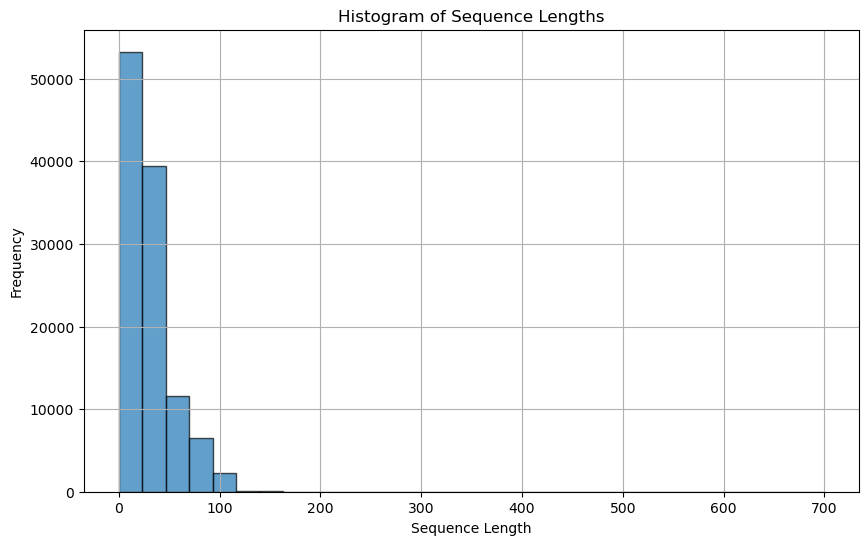

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Tokenize and pad the text data
MAX_NB_WORDS = 50000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df['Content_cleaned'].values)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(df['Content_cleaned'].values)

sequence_lengths = [len(sequence) for sequence in sequences]

# Plot histogram of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Sequence Lengths')
plt.grid(True)
plt.show()

We notice that the majority of our inputs are up to 150 sequence length, therefore we will pad to 170, to contain some edge cases.

In [31]:
MAX_SEQUENCE_LENGTH = 170
EMBEDDING_DIM = 100

X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(le.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
epochs = 3
batch_size = 128

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_classes))

Epoch 1/3


C:\Users\geoch\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


709/709 ━━━━━━━━━━━━━━━━━━━━ 135s 188ms/step - accuracy: 0.7217 - loss: 0.7047 - val_accuracy: 0.8049 - val_loss: 0.5535
Epoch 2/3
709/709 ━━━━━━━━━━━━━━━━━━━━ 129s 181ms/step - accuracy: 0.8096 - loss: 0.5226 - val_accuracy: 0.8109 - val_loss: 0.5151
Epoch 3/3
709/709 ━━━━━━━━━━━━━━━━━━━━ 133s 188ms/step - accuracy: 0.8215 - loss: 0.4745 - val_accuracy: 0.8079 - val_loss: 0.5202
Restoring model weights from the end of the best epoch: 2.
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step
Accuracy: 0.8108919193256543
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     11152
           1       0.20      0.00      0.00      2318
           2       0.82      0.87      0.85      9189

    accuracy                           0.81     22659
   macro avg       0.61      0.60      0.57     22659
weighted avg       0.75      0.81      0.77     22659



In [42]:
MAX_SEQUENCE_LENGTH = 170
EMBEDDING_DIM = 100

X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(le.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
epochs = 3
batch_size = 128

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_classes))

Epoch 1/3


C:\Users\geoch\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


709/709 ━━━━━━━━━━━━━━━━━━━━ 291s 406ms/step - accuracy: 0.7209 - loss: 0.6939 - val_accuracy: 0.8024 - val_loss: 0.5357
Epoch 2/3
709/709 ━━━━━━━━━━━━━━━━━━━━ 290s 409ms/step - accuracy: 0.8117 - loss: 0.5083 - val_accuracy: 0.8103 - val_loss: 0.5160
Epoch 3/3
709/709 ━━━━━━━━━━━━━━━━━━━━ 332s 469ms/step - accuracy: 0.8200 - loss: 0.4781 - val_accuracy: 0.8085 - val_loss: 0.5198
Restoring model weights from the end of the best epoch: 2.
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step
Accuracy: 0.8103181958603646
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     11152
           1       0.37      0.03      0.05      2318
           2       0.83      0.86      0.85      9189

    accuracy                           0.81     22659
   macro avg       0.67      0.61      0.59     22659
weighted avg       0.77      0.81      0.77     22659



In [36]:
word2vec_model = cbow#models.KeyedVectors.load_word2vec_format(
#'../GoogleNews-vectors-negative300.bin', binary=True)

# Tokenize and pad the text data
MAX_SEQUENCE_LENGTH = 170
EMBEDDING_DIM = 300  # Word2Vec model dimension

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Content_cleaned'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df['Content_cleaned'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the embedding matrix
num_words = min(len(word_index) + 1, len(word2vec_model.wv.index_to_key))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.zeros(EMBEDDING_DIM)

# Build the RNN model
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(le.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
epochs = 3
batch_size = 128

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_classes))

Epoch 1/3


C:\Users\geoch\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


709/709 ━━━━━━━━━━━━━━━━━━━━ 167s 233ms/step - accuracy: 0.7428 - loss: 0.6682 - val_accuracy: 0.8047 - val_loss: 0.5278
Epoch 2/3
709/709 ━━━━━━━━━━━━━━━━━━━━ 156s 220ms/step - accuracy: 0.7968 - loss: 0.5469 - val_accuracy: 0.8083 - val_loss: 0.5169
Epoch 3/3
709/709 ━━━━━━━━━━━━━━━━━━━━ 153s 216ms/step - accuracy: 0.8043 - loss: 0.5226 - val_accuracy: 0.8113 - val_loss: 0.5047
Restoring model weights from the end of the best epoch: 3.
178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step
Accuracy: 0.8113332450681848
              precision    recall  f1-score   support

           0       0.81      0.92      0.86     11152
           1       0.36      0.05      0.09      2318
           2       0.82      0.87      0.85      9189

    accuracy                           0.81     22659
   macro avg       0.67      0.61      0.60     22659
weighted avg       0.77      0.81      0.78     22659



In [38]:
# Train the model
epochs = 3
batch_size = 128

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0003), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_classes))

Epoch 1/3
709/709 ━━━━━━━━━━━━━━━━━━━━ 141s 197ms/step - accuracy: 0.8100 - loss: 0.5048 - val_accuracy: 0.8131 - val_loss: 0.4992
Epoch 2/3
709/709 ━━━━━━━━━━━━━━━━━━━━ 136s 192ms/step - accuracy: 0.8142 - loss: 0.4958 - val_accuracy: 0.8147 - val_loss: 0.4970
Epoch 3/3
709/709 ━━━━━━━━━━━━━━━━━━━━ 132s 187ms/step - accuracy: 0.8140 - loss: 0.4930 - val_accuracy: 0.8160 - val_loss: 0.4970
Restoring model weights from the end of the best epoch: 3.
178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step
Accuracy: 0.8159671653647558
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     11152
           1       0.39      0.07      0.12      2318
           2       0.83      0.88      0.85      9189

    accuracy                           0.82     22659
   macro avg       0.68      0.62      0.61     22659
weighted avg       0.78      0.82      0.78     22659



In [67]:
# Path to the GloVe embeddings file
glove_file = '../glove.twitter.27B.100d.txt'

# Load the GloVe embeddings into a dictionary
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Load the GloVe embeddings
embeddings_index  = load_glove_embeddings(glove_file)

# Tokenize and pad the text data
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100  # Word2Vec model dimension

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Content_cleaned'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df['Content_cleaned'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the embedding matrix
num_words = min(len(word_index) + 1, len(word2vec_model.index_to_key))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
        
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
# Build the RNN model
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(le.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 64

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_classes))

Epoch 1/10


C:\Users\geoch\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1417/1417 ━━━━━━━━━━━━━━━━━━━━ 136s 95ms/step - accuracy: 0.7075 - loss: 0.7336 - val_accuracy: 0.7935 - val_loss: 0.5636
Epoch 2/10
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 136s 96ms/step - accuracy: 0.7805 - loss: 0.5941 - val_accuracy: 0.8016 - val_loss: 0.5371
Epoch 3/10
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 133s 94ms/step - accuracy: 0.7873 - loss: 0.5769 - val_accuracy: 0.8054 - val_loss: 0.5256
Epoch 4/10
 399/1417 ━━━━━━━━━━━━━━━━━━━━ 1:34 93ms/step - accuracy: 0.7970 - loss: 0.5473

KeyboardInterrupt: 

### GRU

In [69]:
from tensorflow.keras.layers import GRU

MAX_NB_WORDS = 50000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df['Content_cleaned'].values)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(df['Content_cleaned'].values)

sequence_lengths = [len(sequence) for sequence in sequences]

MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100

X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(le.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
epochs = 3
batch_size = 64

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_classes))

Epoch 1/3


C:\Users\geoch\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1417/1417 ━━━━━━━━━━━━━━━━━━━━ 210s 147ms/step - accuracy: 0.7082 - loss: 3082503936.0000 - val_accuracy: 0.7028 - val_loss: 0.7842
Epoch 2/3
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 221s 156ms/step - accuracy: 0.6973 - loss: 364761710592.0000 - val_accuracy: 0.6833 - val_loss: 0.7870
Epoch 3/3
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 216s 152ms/step - accuracy: 0.7185 - loss: 38482272256.0000 - val_accuracy: 0.6737 - val_loss: 0.8057
355/355 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step
Accuracy: 0.6737278785471557
              precision    recall  f1-score   support

           0       0.69      0.76      0.73     11152
           1       0.50      0.00      0.00      2318
           2       0.65      0.73      0.69      9189

    accuracy                           0.67     22659
   macro avg       0.61      0.50      0.47     22659
weighted avg       0.66      0.67      0.64     22659



In [71]:
word2vec_model = models.KeyedVectors.load_word2vec_format(
'../GoogleNews-vectors-negative300.bin', binary=True)

# Tokenize and pad the text data
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 300  # Word2Vec model dimension

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Content_cleaned'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df['Content_cleaned'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the embedding matrix
num_words = min(len(word_index) + 1, len(word2vec_model.index_to_key))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.zeros(EMBEDDING_DIM)

# Build the RNN model
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(le.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
epochs = 3
batch_size = 64

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_classes))

Epoch 1/3


C:\Users\geoch\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1417/1417 ━━━━━━━━━━━━━━━━━━━━ 181s 126ms/step - accuracy: 0.6479 - loss: 1.6253 - val_accuracy: 0.6702 - val_loss: 0.8088
Epoch 2/3
 634/1417 ━━━━━━━━━━━━━━━━━━━━ 1:39 127ms/step - accuracy: 0.6838 - loss: 0.7939

KeyboardInterrupt: 

### MultiHeadAttention model

In [75]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GlobalAveragePooling1D, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf

# Assuming df is your dataframe and 'Content_cleaned' is the column with cleaned text data
# 'target' is your target variable

# Tokenize and pad the text data
MAX_SEQUENCE_LENGTH = 250
vocab_size = 10000  # Example vocabulary size

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['Content_cleaned'].values)
sequences = tokenizer.texts_to_sequences(df['Content_cleaned'].values)

X = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformer Parameters
embed_dim = 128  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

# Positional Encoding
def positional_encoding(seq_length, embed_dim):
    position_enc = np.array([
        [pos / np.power(10000, 2 * (i // 2) / embed_dim) for i in range(embed_dim)]
        if pos != 0 else np.zeros(embed_dim) for pos in range(seq_length)])
    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2])  # 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2])  # 2i+1
    return position_enc

# Transformer Block
def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, dropout=0.1):
    # Attention and Normalization
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    
    # Feed Forward and Normalization
    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    
    return out2

# Transformer Model
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
position_enc = positional_encoding(MAX_SEQUENCE_LENGTH, embed_dim)
x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs) + position_enc
x = Dropout(0.1)(x)

for _ in range(2):  # Stack 4 transformer layers
    x = transformer_encoder(x, embed_dim, num_heads, ff_dim)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
outputs = Dense(len(le.classes_), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
epochs = 2
batch_size = 64

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_classes))


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)    │ (None, 250)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_8 (Embedding)       │ (None, 250, 128)          │       1,280,000 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_12 (Add)                  │ (None, 250, 128)          │               0 │ embedding_8[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_19 (Dropout)          │ (None, 250, 128)          │               0 │ add_12[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_5        │ (None, 250, 128)          │         527,488 │ dropout_19[0][0],          │
│ (MultiHeadAttention)          │                           │                 │ dropout_19[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_21 (Dropout)          │ (None, 250, 128)          │               0 │ multi_head_attention_5[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_13 (Add)                  │ (None, 250, 128)          │               0 │ dropout_19[0][0],          │
│                               │                           │                 │ dropout_21[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_10        │ (None, 250, 128)          │             256 │ add_13[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_18 (Dense)              │ (None, 250, 128)          │          16,512 │ layer_normalization_10[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_19 (Dense)              │ (None, 250, 128)          │          16,512 │ dense_18[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_22 (Dropout)          │ (None, 250, 128)          │               0 │ dense_19[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_14 (Add)                  │ (None, 250, 128)          │               0 │ layer_normalization_10[0]… │
│                               │                           │                 │ dropout_22[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_11        │ (None, 250, 128)          │             256 │ add_14[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_6        │ (None, 250, 128)          │         527,488 │ layer_normalization_11[0]… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_11[0]… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 2,402,435 (9.16 MB)

 Trainable params: 2,402,435 (9.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 1051s 738ms/step - accuracy: 0.6337 - loss: 0.8257 - val_accuracy: 0.7998 - val_loss: 0.5525
Epoch 2/2
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 1105s 780ms/step - accuracy: 0.8013 - loss: 0.5515 - val_accuracy: 0.7908 - val_loss: 0.5673
Restoring model weights from the end of the best epoch: 1.
709/709 ━━━━━━━━━━━━━━━━━━━━ 92s 130ms/step
Accuracy: 0.7998146431881371
              precision    recall  f1-score   support

           0       0.76      0.96      0.85     11152
           1       0.00      0.00      0.00      2318
           2       0.87      0.81      0.84      9189

    accuracy                           0.80     22659
   macro avg       0.54      0.59      0.56     22659
weighted avg       0.73      0.80      0.76     22659



C:\Users\geoch\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\geoch\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\geoch\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### BERT

In [81]:
pip install --upgrade transformers

     ---------------------------------------- 0.0/43.6 kB ? eta -:--:--
     ---------------------------------------- 43.6/43.6 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.3 MB 5.2 MB/s eta 0:00:02
   --- ------------------------------------ 0.8/9.3 MB 8.4 MB/s eta 0:00:02
   ----- ---------------------------------- 1.4/9.3 MB 9.5 MB/s eta 0:00:01
   -------- ------------------------------- 1.9/9.3 MB 10.2 MB/s eta 0:00:01
   ---------- ----------------------------- 2.5/9.3 MB 10.6 MB/s eta 0:00:01
   ------------- -------------------------- 3.1/9.3 MB 10.9 MB/s eta 0:00:01
   --------------- ------------------------ 3.6/9.3 MB 11.0 MB/s eta 0:00:01
   --------------- ------------------------ 3.7/9.3 MB 11.2 MB/s eta 0:00:01
   ---------------- ----------------------- 3.9/9.3 MB 9.2 MB/s eta 0:00:01
   ------------------ --------------------- 4.4/9.3 MB 9.3 MB/s eta 0:00:01
   -----------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2024.6.1 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [83]:
from transformers import BertTokenizer, TFBertForSequenceClassification

X = df['Content_cleaned'].values
y = df['Sentiment'].values

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize inputs
max_length = 128  # Max length of input tokens
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_length)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(len(X_train)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(32)

# Load pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
epochs = 3  # You can adjust this
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

# Evaluate the model
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred.logits, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))


TypeError: 'BertTokenizer' object is not callable